In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scipy.signal as signal
from sklearn.cluster import KMeans
import circle_fit as cf
from scipy import stats

In [2]:
data_dir = '/mnt/sdb/data/Openedsdata2020/openEDS2020-GazePrediction/train/sequences/' #6873/000.png'
directories = os.listdir(data_dir)

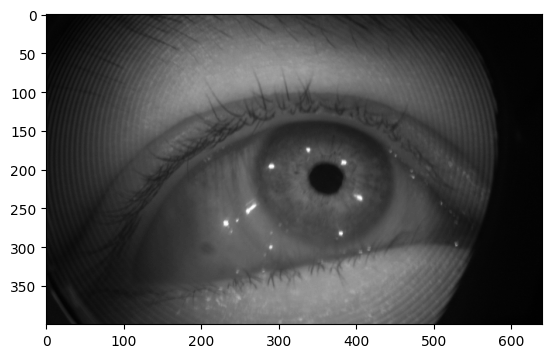

In [3]:
temp_dir = '6840'
files = os.listdir(data_dir + temp_dir)
image = np.zeros(plt.imread(data_dir + temp_dir + '/' + files[0]).shape)
for img in files:
	image += plt.imread(data_dir + temp_dir + '/' + img)
# image /= len(files)+1
plt.imshow(image, cmap='gray')

In [4]:
def auto_cluter(img, iris, dist_to_iris_threshold=110, iris_square_dim=100, white_threshold = 160, dist=15, cluster_size=60):
	# img[iris[0]-5:iris[0]+5, iris[1]-5:iris[1]+5] = 255
	# plt.imshow(img, cmap='gray')
	iris_img = img[max(0, iris[0]-iris_square_dim): min(iris[0]+iris_square_dim, img.shape[0]), max(0, iris[1]-iris_square_dim): min(iris[1]+iris_square_dim, img.shape[1])].copy()
	high_pass_filter = np.array([	[-1, -1, -1, -1, -1],
									[-1,  2,  2,  2, -1],
									[-1,  2,  4,  2, -1],
									[-1,  2,  2,  2, -1],
									[-1, -1, -1, -1, -1]])
	highpass_img = signal.convolve2d(torch.tensor(iris_img), high_pass_filter, mode='same', fillvalue=0)
	highpass_img = (highpass_img / np.max(highpass_img) * 255).astype(int)
	# plt.imshow(highpass_img, cmap='gray')
	x, y = np.where(highpass_img > white_threshold, 255, 0).nonzero()
	coordinates = np.array(list(zip(x, y)))
	dist_to_iris = np.linalg.norm(np.array(coordinates) - np.array([iris_square_dim, iris_square_dim]), axis=1)
	coordinates = coordinates[dist_to_iris < dist_to_iris_threshold]
	classes = []
	for i in range(len(coordinates)):
		if i == 0:
			classes.append([coordinates[i]])
		else:
			for j in range(len(classes)):
				if np.linalg.norm(np.array(coordinates[i]) - np.array(classes[j][0])) < dist:
					classes[j].append(coordinates[i])
					break
				elif j == len(classes)-1:
					classes.append([coordinates[i]])
	cluster_sizes = []
	clusters_centers = []
	clusters = []
	for i in range(len(classes)):
		# center = np.mean(np.array(classes[i]), axis=0).astype(int)
		if len(classes[i]) < cluster_size:
			clusters_centers.append(np.mean(np.array(classes[i])-[iris_square_dim, iris_square_dim]+iris, axis=0).astype(int).tolist())
			clusters.append([list(item-[iris_square_dim, iris_square_dim]+iris) for item in classes[i]])
			cluster_sizes.append(len(classes[i]))
	return clusters, clusters_centers, cluster_sizes

In [360]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return np.array([sum_x/length, sum_y/length])
	
def pupil_locate(img, black_threshold=50, estimate_x=(100, 350), estimate_y=(200, 500), plot = False):
	cropped_img = img[estimate_x[0]:estimate_x[1], estimate_y[0]:estimate_y[1]]

	if plot:
		plt.imshow(cropped_img, cmap='gray')
		
	x, y = np.where(cropped_img < black_threshold, 255, 0).nonzero()
	coordinates = list(zip(np.array(x)+estimate_x[0], np.array(y)+estimate_y[0]))
	low_pass_filter = np.ones((15, 15))
	smoothed_img = signal.convolve2d(torch.tensor(cropped_img), low_pass_filter, mode='same', fillvalue=255)
	smoothed_img = (smoothed_img / smoothed_img.max() * 255).astype(int)
	low_colors = np.sort(smoothed_img.flatten())[700]
	x, y = np.where(smoothed_img <= low_colors, 255, 0).nonzero()
	coordinates = np.array(list(zip(np.array(x), np.array(y))))
	centroid = centeroidnp(coordinates).astype(int)

	radius = np.max(np.linalg.norm(coordinates - centroid, axis=1))

	return centroid[0]+estimate_x[0], centroid[1]+estimate_y[0], radius

In [361]:
def r_theta_eliminate(clusters, iris, angle_resolution):
	theta = np.array([np.arctan2(i[1], i[0]) for i in clusters-iris])
	r = np.array([np.linalg.norm(i-iris) for i in clusters])
	delta_theta = np.array([np.abs(theta - i) for i in theta])
	survived = []
	for i in range(delta_theta.shape[0]):
		less_than = (delta_theta[i] < angle_resolution) & (delta_theta[i] > 0)
		if np.any(less_than):
			if np.all(r[i] < r[less_than]):
				survived.append(clusters[i])
		else:
			survived.append(clusters[i])
	# for i in (np.abs(stats.zscore(survived)) < 3)
	# print((np.abs(stats.zscore(survived)) < 3))
	return np.array(survived)

In [367]:
def iris_locate(img, max_lights=8, iris_diameter=80, circle_fit = True, mark_image = False):
	angle_resolution = ((180 / max_lights)-7) / 180 * (2*np.pi)

	img = np.array(img / img.max() * 255).astype(np.uint8)
	
	# locate the pupil location
	pupil_x, pupil_y, pupil_radius = pupil_locate(img, plot=mark_image)
	pupil = np.array([pupil_x, pupil_y])

	# find the white clusters
	clusters, cluster_centers, cluster_cnt = auto_cluter(img, pupil)
	dist_to_pupil = np.linalg.norm(np.array(cluster_centers) - np.array(pupil), axis=1)

	# eliminate extra noise
	cluster_centers = r_theta_eliminate(np.array(cluster_centers), pupil, angle_resolution)	

	# find the circle that fits the lights
	if circle_fit:
		try:
			xc, yc, r, sigma = cf.taubinSVD(cluster_centers)
			ret_val = np.array([xc, yc, r, sigma])
		except:
			x_min, x_max = np.min(cluster_centers[:, 0]), np.max(cluster_centers[:, 0])
			y_min, y_max = np.min(cluster_centers[:, 1]), np.max(cluster_centers[:, 1])
			ret_val = np.array([x_min, x_max, y_min, y_max])
			return ret_val
	else:
		x_min, x_max = np.min(cluster_centers[:, 0]), np.max(cluster_centers[:, 0])
		y_min, y_max = np.min(cluster_centers[:, 1]), np.max(cluster_centers[:, 1])
		ret_val = np.array([x_min, x_max, y_min, y_max])
	
	if mark_image:
		# mark the locations of the lights on the image
		for i in range(len(cluster_centers)):
			img[cluster_centers[i][0]-10:cluster_centers[i][0]+10, cluster_centers[i][1]-10:cluster_centers[i][1]+10] = 255

		# mark the locations of the pupils on the image
		for i in range(360):
			x = int(pupil_x + pupil_radius * np.cos(i * np.pi / 180))
			y = int(pupil_y + pupil_radius * np.sin(i * np.pi / 180))
			img[min(x, img.shape[0]-1), min(y, img.shape[1]-1)] = 255

		# draw circle
		if circle_fit:
			for i in range(360):
				x = int(xc + r * np.cos(i * np.pi / 180))
				y = int(yc + r * np.sin(i * np.pi / 180))
				img[min(x, img.shape[0]-1), min(y, img.shape[1]-1)] = 255
		else:
			img[x_min, y_min:y_max] = 255
			img[x_max, y_min:y_max] = 255
			img[x_min:x_max, y_min] = 255
			img[x_min:x_max, y_max] = 255
		plt.imshow(img, cmap='gray')

	return ret_val

array([167.75956245, 389.45014707,  51.18610234,   1.03124648])

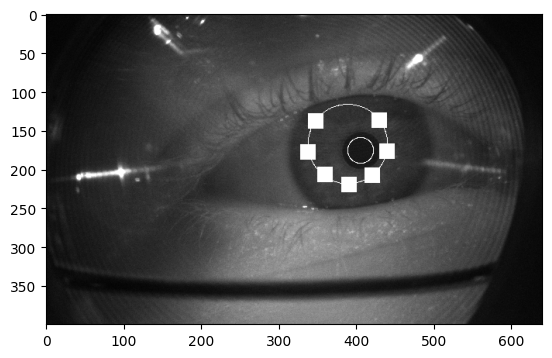

In [373]:
np.random.shuffle(directories)
directory = directories[0]
files = os.listdir(data_dir + directory)
img_path = data_dir + directory + '/' + np.random.choice(files)
img = (plt.imread(img_path) * 255).astype(np.uint8)

pupil_locate(img, plot=True)
iris_locate(img, circle_fit=True, mark_image=True)

223.73769589016916 316.13646007944067 65.6832415374161 1.4076802622426714


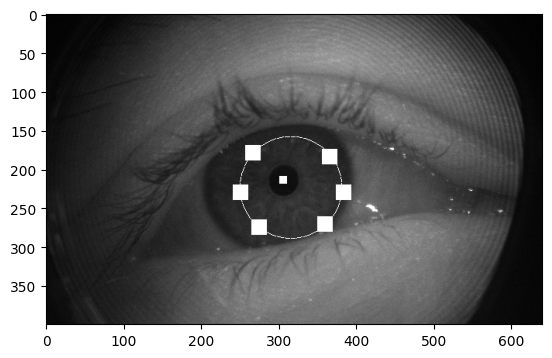

In [9]:
max_lights = 8
angle_resolution = ((135/6)-7)/180*2*np.pi
pupil_diameter=80
np.random.shuffle(directories)
pupil_colors = []
for directory in directories[:1000]:
	files = os.listdir(data_dir + directory)
	img_path = data_dir + directory + '/' + np.random.choice(files)
	img = (plt.imread(img_path) * 255).astype(np.uint8)
	roi = img.copy()[100:350, 200:500]

	pupil_x, pupil_y = pupil_locate(img)
	pupil = np.array([pupil_x, pupil_y])

	# find the white cluster
	clusters, cluster_centers, cluster_cnt = auto_cluter(img, pupil)
	dist_to_pupil = np.linalg.norm(np.array(cluster_centers) - np.array(pupil), axis=1)
	
	cluster_centers = r_theta_eliminate(np.array(cluster_centers), pupil, angle_resolution)
	for i in range(len(cluster_centers)):
		img[cluster_centers[i][0]-10:cluster_centers[i][0]+10, cluster_centers[i][1]-10:cluster_centers[i][1]+10] = 255

	# try:
	xc, yc, r, sigma = cf.taubinSVD(cluster_centers)
	print(xc, yc, r, sigma)
	img[pupil_x-5:pupil_x+5, pupil_y-5:pupil_y+5] = 255
	# draw circle
	for i in range(360):
		x = int(xc + r * np.cos(i * np.pi / 180))
		y = int(yc + r * np.sin(i * np.pi / 180))
		img[min(x, img.shape[0]-1), min(y, img.shape[1]-1)] = 255
	plt.imshow(img, cmap='gray')
		# pupil_colors += list(img[int(xc-r):int(xc+r), int(yc-r):int(yc+r)].flatten())
	# except:
	# 	continue
	break

<BarContainer object of 242 artists>

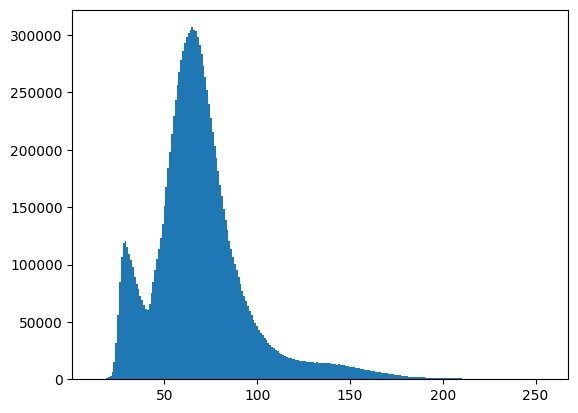

In [1094]:
hist = Counter(iris_colors)
hist[255]=0
all_peak_height = list(hist.values())
x = np.array(list(hist.keys()))
plt.bar(x, all_peak_height, width=1)